# Fit Multiple Noisy Traces HH to HH

In [1]:
import pandas as pd
import numpy as np

In [2]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [34]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area),
                  'Cm': float(1*ufarad*cm**-2 * area), 
                  'El': float(-65*mV),
                  'EK': float(-90*mV),
                  'ENa': float(50*mV),}

dt = 0.01*ms
defaultclock.dt = dt

In [35]:
params_correct

{'gl': 1e-08,
 'g_na': 2e-05,
 'g_kd': 6e-06,
 'Cm': 2e-10,
 'El': -0.065,
 'EK': -0.09,
 'ENa': 0.05}

### Load Input and Output

In [5]:
df_inp_traces = pd.read_csv('input_traces_hh.csv')
df_out_traces = pd.read_csv('output_traces_hh.csv')

In [6]:
inp_traces = df_inp_traces.to_numpy()
inp_traces = inp_traces[:, 1:]
inp_traces

array([[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e-09, 2.e-09, 2.e-09, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
       [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]])

In [7]:
out_traces = df_out_traces.to_numpy()
out_traces = out_traces[:, 1:]
out_traces

array([[-63.54211145, -65.52491616, -62.90054542, ..., -81.5252667 ,
        -82.30107475, -82.04870895],
       [-63.78548155, -64.75587972, -64.60550311, ..., -64.42127691,
        -65.13069593, -64.48718384],
       [-62.92648395, -65.82540807, -64.76394825, ..., -64.9418292 ,
        -63.8704734 , -63.17105741],
       [-64.51645049, -66.84945425, -64.64260378, ..., -80.91299455,
        -79.08977935, -82.01562544],
       [-65.57417095, -65.68558642, -65.67498994, ..., -59.60054522,
        -60.47494105, -60.01392187]])

## Model Fitting 

In [9]:
eqs = Equations(
'''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
Cm   : farad (constant)
El  : volt(constant)
EK  : volt(constant)
ENa : volt(constant)
''',
# El=-65*mV, EK=-90*mV, ENa=50*mV,
VT=-63*mV)

In [62]:
def callback(res, errors, parameters, index):
    print('index {} errors minimum: {}'.format(index, min(errors)) )

In [49]:
start_scope()
n_opt = NevergradOptimizer(method='DE')

metric = MSEMetric()

In [55]:
n_opt.optim.budget = 100

In [56]:
n_opt.optim

Instance of DE(instrumentation=A(1,[At(0.03,0.055)])f,A(1,[At(6e-07,6e-05)])f,A(1,[At(1e-09,1e-07)])f,A(1,[At(-0.1,-0.06)])f,A(1,[At(2e-06,0.0002)])f,A(1,[At(-0.1,-0.06)])f,A(1,[At(2.0000000000000002e-11,4e-10)])f, budget=100, num_workers=1)

In [57]:
res, error = fit_traces(model=eqs, input_var='I', output_var='v',
                       input=inp_traces * amp, output=out_traces*mV, dt=dt,
                       method='exponential_euler',
                       callback=callback,
                       gl = [1e-09 *siemens, 1e-07 *siemens],
                       g_na = [2e-06*siemens, 2e-04*siemens],
                       g_kd = [6e-07*siemens, 6e-05*siemens],
                       Cm=[0.1*ufarad*cm**-2 * area, 2*ufarad*cm**-2 * area],
                       El=[-100*mV, -60*mV],
                       EK=[-100*mV, -60*mV],
                       ENa=[30*mV, 55*mV],
                       n_rounds=100, n_samples=30, optimizer=n_opt, 
                       metric=metric)

index 0 errors minimum: 0.8994909896783977
index 1 errors minimum: 0.7318714498762601
index 2 errors minimum: 0.698931026707813
index 3 errors minimum: 0.6731241499709227
index 4 errors minimum: 0.6537514152904647
index 5 errors minimum: 0.6221982933023471
index 6 errors minimum: 0.5625065778505517
index 7 errors minimum: 0.5907103196871136
index 8 errors minimum: 0.5898336769734032
index 9 errors minimum: 0.565186771836314
index 10 errors minimum: 0.5717491700185379
index 11 errors minimum: 0.5297536477128346
index 12 errors minimum: 0.6088539483112607
index 13 errors minimum: 0.6068256422425582
index 14 errors minimum: 0.5297536477128346
index 15 errors minimum: 0.5589646635938752
index 16 errors minimum: 0.5849803762153056
index 17 errors minimum: 0.5644716271934922
index 18 errors minimum: 0.5597698239696021
index 19 errors minimum: 0.5750103382204516
index 20 errors minimum: 0.5548585216013165
index 21 errors minimum: 0.5847636528771943
index 22 errors minimum: 0.5416616605135481


In [58]:
print('Goal parameters:')
for param in params_correct.items():
    print(param)

Goal parameters:
('gl', 1e-08)
('g_na', 2e-05)
('g_kd', 6e-06)
('Cm', 2e-10)
('El', -0.065)
('EK', -0.09)
('ENa', 0.05)


In [59]:
print('Result parameters:')
for param in res.items():
    print(param)

Result parameters:
('ENa', 0.03401190447773755)
('g_kd', 4.935058463057514e-05)
('gl', 2.901130904236476e-08)
('EK', -0.07049764531813979)
('g_na', 6.644545565039473e-05)
('El', -0.07207294122261104)
('Cm', 1.55681573466657e-10)


## Results Visualization

In [60]:
start_scope()
fits = generate_fits(model=eqs, method='exponential_euler', params=res,
                     input=inp_traces * amp, input_var='I', output_var='v',
                     dt=dt, param_init={'v': -65*mV})

fits/mV

array([[-65.        , -65.01316817, -65.02631183, ..., -71.186589  ,
        -71.18823054, -71.18986906],
       [-65.        , -65.01316817, -65.02631183, ..., -71.01234166,
        -71.01429171, -71.01623853],
       [-65.        , -64.88482044, -64.76985532, ..., -71.34829937,
        -71.34964205, -71.35098224],
       [-65.        , -65.01316817, -65.02631183, ..., -71.25481322,
        -71.25632913, -71.25784224],
       [-65.        , -65.01316817, -65.02631183, ..., -69.95496629,
        -69.95889296, -69.96281237]])

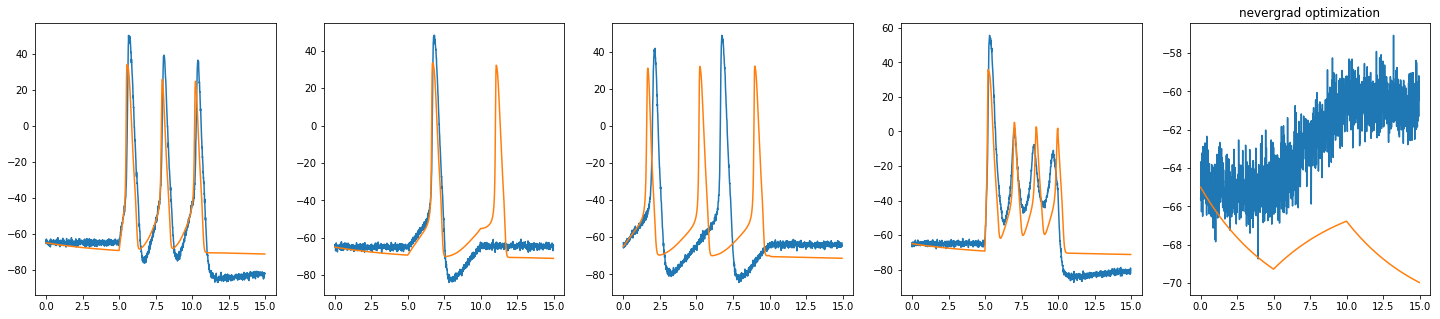

In [61]:
fig, ax = plt.subplots(ncols=5, figsize=(25, 5))
ax[0].plot(np.arange(len(out_traces[0]))*dt/ms, out_traces[0]);
ax[0].plot(np.arange(len(fits[0]))*dt/ms, fits[0]/mV);

ax[1].plot(np.arange(len(out_traces[1]))*dt/ms, out_traces[1]);
ax[1].plot(np.arange(len(fits[1]))*dt/ms, fits[1]/mV);

ax[2].plot(np.arange(len(out_traces[2]))*dt/ms, out_traces[2]);
ax[2].plot(np.arange(len(fits[2]))*dt/ms, fits[2]/mV);

ax[3].plot(np.arange(len(out_traces[3]))*dt/ms, out_traces[3]);
ax[3].plot(np.arange(len(fits[3]))*dt/ms, fits[3]/mV);

ax[4].plot(np.arange(len(out_traces[4]))*dt/ms, out_traces[4]);
ax[4].plot(np.arange(len(fits[4]))*dt/ms, fits[4]/mV);

plt.title('nevergrad optimization')
plt.show()